In [14]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from simglucose.controller.base import Controller, Action
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from datetime import timedelta
from datetime import datetime

In [2]:
def make(seed):
    # specify start_time as the beginning of today
    now = datetime.now()
    start_time = datetime.combine(now.date(), datetime.min.time())

    # Specify results saving path
    path = './results'

    # Create a simulation environment
    patient = T1DPatient.withName('adolescent#002')
    sensor = CGMSensor.withName('Dexcom')
    pump = InsulinPump.withName('Insulet')
    scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
    scenario = CustomScenario(start_time=start_time, scenario=scen)
    env = T1DSimEnv(patient, sensor, pump, scenario)
    return env

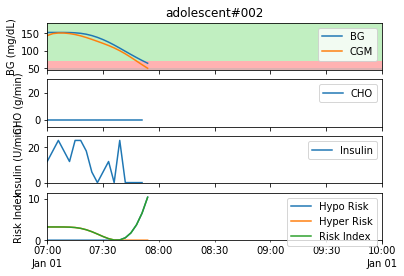

In [9]:
n = 1; returns = np.zeros(n)
for i in range(n):
    #env = make(i)
    #env = gym.make('simglucose-adolescent2-v0')
    obs = env.reset()
    ret = 0
    done = False
    while not done:
        action = np.random.randint(5)
        obs, rew, done, info = env.step(action)
        env.render()
        ret += rew
    returns[i] = ret

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [5]:
sns.distplot(returns, bins=15);

NameError: name 'returns' is not defined

In [3]:
import gym
from gym.envs.registration import register
register(
    id='simglucose-adolescent2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002',
           'num_action': 5}
)
env = gym.make('simglucose-adolescent2-v0')

/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [54]:
import os
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque
from skimage.color import rgb2gray
from skimage.transform import resize
from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, Dense

ENV_NAME = 'simglucose-adolescent2-v0'  # Environment name
# FRAME_WIDTH = 84  # Resized frame width
# FRAME_HEIGHT = 84  # Resized frame height
NUM_EPISODES = 12000  # Number of episodes the agent plays
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network
GAMMA = 0.99  # Discount factor
EXPLORATION_STEPS = 1000  # Number of steps over which the initial value of epsilon is linearly annealed to its final value
INITIAL_EPSILON = 1.0  # Initial value of epsilon in epsilon-greedy
FINAL_EPSILON = 0.1  # Final value of epsilon in epsilon-greedy
INITIAL_REPLAY_SIZE = 2000  # Number of steps to populate the replay memory before training starts
NUM_REPLAY_MEMORY = 40000  # Number of replay memory the agent uses for training
BATCH_SIZE = 32  # Mini batch size
TARGET_UPDATE_INTERVAL = 1000  # The frequency with which the target network is updated
TRAIN_INTERVAL = 4  # The agent selects 4 actions between successive updates
LEARNING_RATE = 0.00025  # Learning rate used by RMSProp
MOMENTUM = 0.95  # Momentum used by RMSProp
MIN_GRAD = 0.01  # Constant added to the squared gradient in the denominator of the RMSProp update
SAVE_INTERVAL = 300000  # The frequency with which the network is saved
NO_OP_STEPS = 30  # Maximum number of "do nothing" actions to be performed by the agent at the start of an episode
LOAD_NETWORK = False
TRAIN = True
SAVE_NETWORK_PATH = 'saved_networks/' + ENV_NAME
SAVE_SUMMARY_PATH = 'summary/' + ENV_NAME
NUM_EPISODES_AT_TEST = 30  # Number of episodes the agent plays at test time


class Agent():
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.epsilon = INITIAL_EPSILON
        self.epsilon_step = (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS
        self.t = 0

        # Parameters used for summary
        self.total_reward = 0
        self.total_q_max = 0
        self.total_loss = 0
        self.duration = 0
        self.episode = 0

        # Create replay memory
        self.replay_memory = deque()

        # Create q network
        self.s, self.q_values, q_network = self.build_network()
        q_network_weights = q_network.trainable_weights

        # Create target network
        self.st, self.target_q_values, target_network = self.build_network()
        target_network_weights = target_network.trainable_weights

        # Define target network update operation
        self.update_target_network = [target_network_weights[i].assign(q_network_weights[i]) for i in range(len(target_network_weights))]

        # Define loss and gradient update operation
        self.a, self.y, self.loss, self.grads_update = self.build_training_op(q_network_weights)

        self.sess = tf.InteractiveSession()
        self.saver = tf.train.Saver(q_network_weights)
        self.summary_placeholders, self.update_ops, self.summary_op = self.setup_summary()
        self.summary_writer = tf.train.SummaryWriter(SAVE_SUMMARY_PATH, self.sess.graph)

        if not os.path.exists(SAVE_NETWORK_PATH):
            os.makedirs(SAVE_NETWORK_PATH)

        self.sess.run(tf.initialize_all_variables())

        # Load network
        if LOAD_NETWORK:
            self.load_network()

        # Initialize target network
        self.sess.run(self.update_target_network)

    def build_network(self):
        model = Sequential()
        model.add(Dense(32, activation='relu', input_shape=(STATE_LENGTH)))
        model.add(Dense(32, activation='relu', input_shape=(STATE_LENGTH)))
        model.add(Dense(32, activation='relu', input_shape=(STATE_LENGTH)))

        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.num_actions))

        s = tf.placeholder(tf.float32, [None, STATE_LENGTH])
        q_values = model(s)

        return s, q_values, model

    def build_training_op(self, q_network_weights):
        a = tf.placeholder(tf.int64, [None])
        y = tf.placeholder(tf.float32, [None])

        # Convert action to one hot vector
        a_one_hot = tf.one_hot(a, self.num_actions, 1.0, 0.0)
        q_value = tf.reduce_sum(tf.mul(self.q_values, a_one_hot), reduction_indices=1)

        # Clip the error, the loss is quadratic when the error is in (-1, 1), and linear outside of that region
        error = tf.abs(y - q_value)
        quadratic_part = tf.clip_by_value(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = tf.reduce_mean(0.5 * tf.square(quadratic_part) + linear_part)

        optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE, momentum=MOMENTUM, epsilon=MIN_GRAD)
        grads_update = optimizer.minimize(loss, var_list=q_network_weights)

        return a, y, loss, grads_update

    def process(self, state):
        
    def get_initial_state(self, observation):
        #processed_observation = np.maximum(observation, last_observation)
        #processed_observation = np.uint8(resize(rgb2gray(processed_observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
        processed_observation = (observation - np.array([193.0]))/(np.array([111.0]))
        state = [processed_observation for _ in range(STATE_LENGTH)]
        return np.stack(state, axis=0)

    def get_action(self, state):
        if self.epsilon >= random.random() or self.t < INITIAL_REPLAY_SIZE:
            action = random.randrange(self.num_actions)
        else:
            action = np.argmax(self.q_values.eval(feed_dict={self.s: state}))

        # Anneal epsilon linearly over time
        if self.epsilon > FINAL_EPSILON and self.t >= INITIAL_REPLAY_SIZE:
            self.epsilon -= self.epsilon_step

        return action

    def run(self, state, action, reward, terminal, observation):
        next_state = np.append(state[1:], observation, axis=0)

        # Clip all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged
        reward = np.clip(reward, -1, 1)

        # Store transition in replay memory
        self.replay_memory.append((state, action, reward, next_state, terminal))
        if len(self.replay_memory) > NUM_REPLAY_MEMORY:
            self.replay_memory.popleft()

        if self.t >= INITIAL_REPLAY_SIZE:
            # Train network
            if self.t % TRAIN_INTERVAL == 0:
                self.train_network()

            # Update target network
            if self.t % TARGET_UPDATE_INTERVAL == 0:
                self.sess.run(self.update_target_network)

            # Save network
            if self.t % SAVE_INTERVAL == 0:
                save_path = self.saver.save(self.sess, SAVE_NETWORK_PATH + '/' + ENV_NAME, global_step=self.t)
                print('Successfully saved: ' + save_path)

        self.total_reward += reward
        self.total_q_max += np.max(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))
        self.duration += 1

        if terminal:
            # Write summary
            if self.t >= INITIAL_REPLAY_SIZE:
                stats = [self.total_reward, self.total_q_max / float(self.duration),
                        self.duration, self.total_loss / (float(self.duration) / float(TRAIN_INTERVAL))]
                for i in range(len(stats)):
                    self.sess.run(self.update_ops[i], feed_dict={
                        self.summary_placeholders[i]: float(stats[i])
                    })
                summary_str = self.sess.run(self.summary_op)
                self.summary_writer.add_summary(summary_str, self.episode + 1)

            # Debug
            if self.t < INITIAL_REPLAY_SIZE:
                mode = 'random'
            elif INITIAL_REPLAY_SIZE <= self.t < INITIAL_REPLAY_SIZE + EXPLORATION_STEPS:
                mode = 'explore'
            else:
                mode = 'exploit'
            print('EPISODE: {0:6d} / TIMESTEP: {1:8d} / DURATION: {2:5d} / EPSILON: {3:.5f} / TOTAL_REWARD: {4:3.0f} / AVG_MAX_Q: {5:2.4f} / AVG_LOSS: {6:.5f} / MODE: {7}'.format(
                self.episode + 1, self.t, self.duration, self.epsilon,
                self.total_reward, self.total_q_max / float(self.duration),
                self.total_loss / (float(self.duration) / float(TRAIN_INTERVAL)), mode))

            self.total_reward = 0
            self.total_q_max = 0
            self.total_loss = 0
            self.duration = 0
            self.episode += 1

        self.t += 1

        return next_state

    def train_network(self):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        terminal_batch = []
        y_batch = []

        # Sample random minibatch of transition from replay memory
        minibatch = random.sample(self.replay_memory, BATCH_SIZE)
        for data in minibatch:
            state_batch.append(data[0])
            action_batch.append(data[1])
            reward_batch.append(data[2])
            next_state_batch.append(data[3])
            terminal_batch.append(data[4])

        # Convert True to 1, False to 0
        terminal_batch = np.array(terminal_batch) + 0

        target_q_values_batch = self.target_q_values.eval(feed_dict={self.st: np.float32(np.array(next_state_batch) / 255.0)})
        y_batch = reward_batch + (1 - terminal_batch) * GAMMA * np.max(target_q_values_batch, axis=1)

        loss, _ = self.sess.run([self.loss, self.grads_update], feed_dict={
            self.s: np.float32(np.array(state_batch) / 255.0),
            self.a: action_batch,
            self.y: y_batch
        })

        self.total_loss += loss

    def setup_summary(self):
        episode_total_reward = tf.Variable(0.)
        tf.scalar_summary(ENV_NAME + '/Total Reward/Episode', episode_total_reward)
        episode_avg_max_q = tf.Variable(0.)
        tf.scalar_summary(ENV_NAME + '/Average Max Q/Episode', episode_avg_max_q)
        episode_duration = tf.Variable(0.)
        tf.scalar_summary(ENV_NAME + '/Duration/Episode', episode_duration)
        episode_avg_loss = tf.Variable(0.)
        tf.scalar_summary(ENV_NAME + '/Average Loss/Episode', episode_avg_loss)
        summary_vars = [episode_total_reward, episode_avg_max_q, episode_duration, episode_avg_loss]
        summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
        update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
        summary_op = tf.merge_all_summaries()
        return summary_placeholders, update_ops, summary_op

    def load_network(self):
        checkpoint = tf.train.get_checkpoint_state(SAVE_NETWORK_PATH)
        if checkpoint and checkpoint.model_checkpoint_path:
            self.saver.restore(self.sess, checkpoint.model_checkpoint_path)
            print('Successfully loaded: ' + checkpoint.model_checkpoint_path)
        else:
            print('Training new network...')

    def get_action_at_test(self, state):
        if random.random() <= 0.05:
            action = random.randrange(self.num_actions)
        else:
            action = np.argmax(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))

        self.t += 1

        return action


def preprocess(observation, last_observation):
    processed_observation = np.maximum(observation, last_observation)
    processed_observation = np.uint8(resize(rgb2gray(processed_observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
    return np.reshape(processed_observation, (1, FRAME_WIDTH, FRAME_HEIGHT))

In [ ]:
def main():
    env = gym.make(ENV_NAME)
    agent = Agent(num_actions=env.action_space.n)

    if TRAIN:  # Train mode
        for _ in range(NUM_EPISODES):
            terminal = False
            observation = env.reset()
            for _ in range(random.randint(1, NO_OP_STEPS)):
                last_observation = observation
                observation, _, _, _ = env.step(0)  # Do nothing
            state = agent.get_initial_state(observation, last_observation)
            while not terminal:
                last_observation = observation
                action = agent.get_action(state)
                observation, reward, terminal, _ = env.step(action)
                # env.render()
                processed_observation = preprocess(observation, last_observation)
                state = agent.run(state, action, reward, terminal, processed_observation)
    else:  # Test mode
        # env.monitor.start(ENV_NAME + '-test')
        for _ in range(NUM_EPISODES_AT_TEST):
            terminal = False
            observation = env.reset()
            for _ in range(random.randint(1, NO_OP_STEPS)):
                last_observation = observation
                observation, _, _, _ = env.step(0)  # Do nothing
            state = agent.get_initial_state(observation, last_observation)
            while not terminal:
                last_observation = observation
                action = agent.get_action_at_test(state)
                observation, _, terminal, _ = env.step(action)
                env.render()
                processed_observation = preprocess(observation, last_observation)
                state = np.append(state[1:, :, :], processed_observation, axis=0)
        # env.monitor.close()


if __name__ == '__main__':
    main()

In [55]:
def process(state):
    return (state - np.array([193.0]))/(np.array([111.0]))

In [56]:
env = gym.make('simglucose-adolescent2-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(action_size, state_size)
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")
done = False
batch_size = 32

for e in range(EPISODES):
    state = process(env.reset())
    state = np.reshape(state, [1, state_size])
    ep_rew = 0
    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward/1.95
        next_state = process(next_state)
        ep_rew += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        print(state, action, reward, next_state, done)
        print(agent.model.predict(state))
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, ep_rew, agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


5 1
[[-0.29009149]] 3 -0.13737625448559 [[-0.28828897]] False
[[ 0.28209454  0.19614094  0.46245155  0.48157263 -0.01942982]]
[[-0.28828897]] 4 -0.02915464212078926 [[-0.28501285]] False
[[ 0.28034168  0.19492224  0.45957807  0.47858047 -0.019309  ]]
[[-0.28501285]] 2 0.023880215661339667 [[-0.28769529]] False
[[ 0.27715594  0.19270708  0.4543554   0.4731418  -0.01908962]]
[[-0.28769529]] 4 0.06851212653760587 [[-0.29544177]] False
[[ 0.2797644   0.19452082  0.45863175  0.47759473 -0.01926932]]
[[-0.29544177]] 4 0.11377839199180283 [[-0.30848043]] False
[[ 0.28729725  0.19975853  0.47098088  0.49045464 -0.0197882 ]]
[[-0.30848043]] 2 0.16365295326826967 [[-0.32764957]] False
[[ 0.29997653  0.20857441  0.49176648  0.5120995  -0.02066146]]
[[-0.32764957]] 3 0.21367609323282144 [[-0.35351689]] False
[[ 0.31861722  0.2215352   0.52232504  0.54392165 -0.02194533]]
[[-0.35351689]] 2 0.2523206550479508 [[-0.38553053]] False
[[ 0.3437714   0.23902495  0.5635614   0.5868633  -0.02367772]]
[[-0.

[[-0.69022044]] 0 -0.06680627217860519 [[-0.79360075]] False
[[124.760056 156.81332  114.8266   160.29002  117.54591 ]]
[[-0.79360075]] 0 -0.5362132126054727 [[-0.89829396]] False
[[153.9251  195.73949 143.75252 192.7559  146.2434 ]]
[[-0.89829396]] 0 -1.0996874721821375 [[-0.99669315]] False
[[189.56462 232.55388 161.52927 236.7037  178.75003]]
[[-0.99669315]] 4 -1.6130079331736462 [[-1.08231261]] True
[[236.26045 279.34302 191.83627 281.23386 206.07845]]
episode: 3/10000, score: -1.1727597951167374, e: 0.96
[[-0.29009149]] 3 -0.13737625448559 [[-0.28828897]] False
[[122.626656 144.70862   99.503654 145.7119   107.50516 ]]
[[-0.28828897]] 1 -0.029164015693261547 [[-0.2850118]] False
[[137.99599 155.79485 103.20453 154.10579 112.18478]]
[[-0.2850118]] 3 0.023461155803345218 [[-0.28764708]] False
[[125.97889 146.27559 102.08194 145.64299 100.48092]]
[[-0.28764708]] 3 0.0652741890469212 [[-0.29502528]] False
[[126.08324  151.76756  105.128815 151.1072   101.731094]]
[[-0.29502528]] 1 0.1

[[-0.43756733]] 2 0.28466638229826724 [[-0.48124868]] False
[[38.488377 39.255417 39.867287 36.514545 34.856575]]
[[-0.48124868]] 0 0.28267091642776154 [[-0.53106069]] False
[[38.47175  39.43198  40.125908 36.492447 34.509686]]
[[-0.53106069]] 2 0.27016236895452106 [[-0.59040282]] False
[[38.28695  39.334625 40.212074 35.802372 33.82876 ]]
[[-0.59040282]] 3 0.21262353542328336 [[-0.66192806]] False
[[37.31172  38.31649  39.71529  33.922905 31.446833]]
[[-0.66192806]] 2 0.05681748942841755 [[-0.74669924]] False
[[37.40878  38.481045 40.07016  33.65004  30.505018]]
[[-0.74669924]] 1 -0.26298427601115587 [[-0.84288021]] False
[[37.89844  39.323868 40.74402  33.740257 30.55115 ]]
[[-0.84288021]] 2 -0.780030079741831 [[-0.94413644]] False
[[38.311035 40.297043 41.586506 34.570095 30.96485 ]]
[[-0.94413644]] 1 -1.4649998502214296 [[-1.04356648]] True
[[39.107822 41.500042 42.588608 35.782288 31.924044]]
episode: 7/10000, score: -0.35298232353084313, e: 0.9
[[-0.29009149]] 4 -0.13737310881983

KeyboardInterrupt: 

[-0.13823645] [[54429.008 55389.94  53821.6   55229.69  53918.047]]
[-0.13972763] [[54442.094 55403.266 53834.543 55242.965 53931.008]]
[-0.14390683] [[54478.77  55440.59  53870.81  55280.188 53967.34 ]]
[-0.14722426] [[54507.89  55470.223 53899.6   55309.73  53996.19 ]]
[-0.14990759] [[54531.438 55494.184 53922.887 55333.62  54019.52 ]]
[-0.15279899] [[54556.812 55520.008 53947.984 55359.375 54044.656]]
[-0.15762342] [[54599.15  55563.09  53989.848 55402.336 54086.6  ]]
[-0.16674741] [[54679.227 55644.574 54069.023 55483.59  54165.92 ]]
[-0.18227191] [[54815.47  55783.23  54203.75  55621.832 54300.89 ]]
[-0.20535769] [[55018.066 55989.41  54404.094 55827.418 54501.6  ]]
[-0.23675363] [[55293.6   56269.81  54676.55  56107.004 54774.555]]
[-0.27761443] [[55652.195 56634.742 55031.15  56470.87  55129.8  ]]
[-0.32906513] [[56103.73  57094.254 55477.65  56929.05  55577.12 ]]
[-0.3922272] [[56658.047 57658.36  56025.773 57491.52  56126.254]]
[-0.46810071] [[57323.91  58335.996 56684.22  581

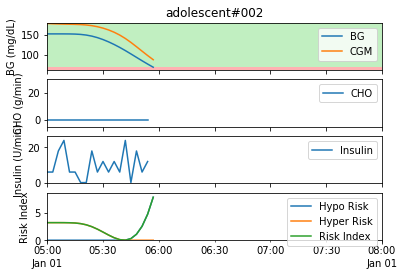

In [53]:
n = 1; returns = np.zeros(n)
for i in range(n):
    #env = make(i)
    #env = gym.make('simglucose-adolescent2-v0')
    obs = process(env.reset())
    ret = 0
    done = False
    while not done:
        action = agent.act(obs)
        print(obs, agent.model.predict(obs))
        obs, rew, done, info = env.step(action)
        obs = process(obs)
        ret += rew
    returns[i] = ret
    env.render()
plt.plot(returns)

In [43]:
agent.epsilon = 0